In [4]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

import albumentations as A
import cv2
from tqdm import tqdm

In [5]:
cancer_rays_dir = os.listdir("./input/IDC_regular_ps50_idx5") 
all_rays_dir = "all_rays_dir"
cancer_rays_dir_str = "./input/IDC_regular_ps50_idx5/"

In [6]:
if not os.path.exists(all_rays_dir):
    os.makedirs(all_rays_dir)
for patient in cancer_rays_dir:   
    path_0 = os.path.join(cancer_rays_dir_str, patient, '0')
    path_1 = os.path.join(cancer_rays_dir_str, patient, '1')
    file_list_0 = os.listdir(path_0)   
    file_list_1 = os.listdir(path_1)
    for fname in file_list_0:
        src = os.path.join(path_0, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)
    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

In [7]:
all_rays_dir_lst = os.listdir(all_rays_dir) 
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])


In [8]:
def get_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=30, p=0.5),
    ])

augmentations = get_augmentations()

In [9]:
# Extract target label from the filename
def extract_target(x):
    return int(x.split('_')[4][5])

In [10]:
data['target'] = data['image_id'].apply(extract_target)

In [11]:
import numpy as np
from collections import Counter
# Check class distribution
print("Original class distribution:", Counter(data['target']))

# Separate data by class
class_0_data = data[data['target'] == 0]
class_1_data = data[data['target'] == 1]

# Balance by undersampling class 0
np.random.seed(42)
n_samples = len(class_1_data)
balanced_class_0_data = class_0_data.sample(n=n_samples, random_state=42)

# Combine the balanced datasets
balanced_data = pd.concat([balanced_class_0_data, class_1_data], ignore_index=True)

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
print("Balanced class distribution:", Counter(balanced_data['target']))

Original class distribution: Counter({0: 198738, 1: 78786})
Balanced class distribution: Counter({0: 78786, 1: 78786})


In [12]:
# Split into train (80%) and test (20%)
train_data, test_data = train_test_split(balanced_data, test_size=0.2, stratify=balanced_data["target"], random_state=42)

# Further split train into train (80%) and validation (20% of train, i.e., 16% of total)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data["target"], random_state=42)

In [13]:
# Create directories
for split in ["train", "val", "test"]:
    split_dir = os.path.join("split_data", split)
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

# Move files into the respective directories
def move_files(split_data, split_name):
    split_dir = os.path.join("split_data", split_name)
    for _, row in tqdm(split_data.iterrows(), total=len(split_data), desc=f"Processing {split_name}"):
        src_path = os.path.join(all_rays_dir, row["image_id"])
        dst_path = os.path.join(split_dir, row["image_id"])
        shutil.copyfile(src_path, dst_path)

move_files(train_data, "train")
move_files(val_data, "val")
move_files(test_data, "test")

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Testing set size: {len(test_data)}")

Processing test: 100%|██████████| 31515/31515 [00:15<00:00, 2070.58it/s]

Training set size: 100845
Validation set size: 25212
Testing set size: 31515


In [14]:
# Feature extraction function using HOG with resizing
def extract_features(image_path):
    image = image_path
    # Convert to grayscale if needed
    if len(image.shape) > 2:
        image = np.mean(image, axis=2)
    # Resize image to 16x16 for HOG compatibility
    image_resized = resize(image, (16, 16), anti_aliasing=True)
    features, _ = hog(image_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

In [15]:
def process_data(data_subset, augment=False, target_size=(256, 256)):
    features = []
    targets = []
    
    for idx, row in tqdm(data_subset.iterrows(), total=len(data_subset), desc="Processing images"):
        path = os.path.join(all_rays_dir, row['image_id'])
        
        # Load the image
        image = cv2.imread(path)
        
        # Resize the image to the target size
        image = cv2.resize(image, target_size)
        
        if augment:  # Apply augmentations only for training
            augmented = augmentations(image=image)
            image = augmented['image']
        
        # Normalize the image
        # image = image / 255.0  # Scale pixel values to [0, 1]
        
        # Add the resized and normalized image to features
        features.append(image)
        targets.append(row['target'])
    
    return np.array(features), np.array(targets)


# Process each subset
X_train, y_train = process_data(train_data, augment=True)  # Augmentations applied
X_val, y_val = process_data(val_data, augment=False)       # No augmentations
X_test, y_test = process_data(test_data, augment=False)    # No augmentations

Processing images: 100%|██████████| 31515/31515 [00:21<00:00, 1474.68it/s]


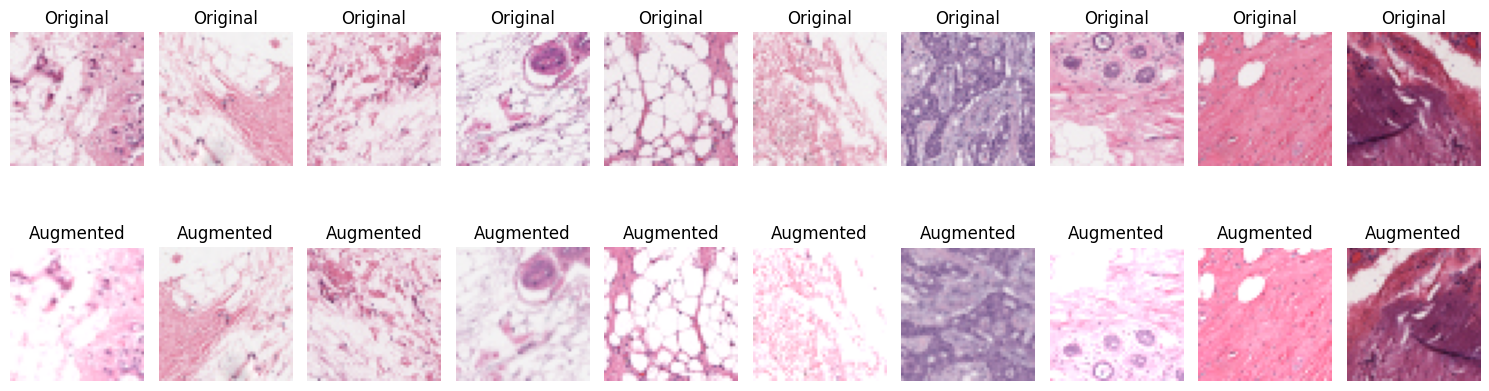

In [22]:
def show_augmented_images(data, augmentations, num_examples=10):
    plt.figure(figsize=(15, 5))
    
    for idx, row in enumerate(data.sample(n=num_examples).itertuples(), 1):
        path = os.path.join(all_rays_dir, row.image_id)
        
        # Load the image
        image = cv2.imread(path)
        # Convert to RGB for displaying (OpenCV loads in BGR by default)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply augmentations
        augmented = augmentations(image=image)
        augmented_image = augmented['image']
        
        # Plot original and augmented images
        plt.subplot(2, num_examples, idx)
        plt.imshow(image)
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, num_examples, idx + num_examples)
        plt.imshow(augmented_image)
        plt.title("Augmented")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Call the function to display the images
show_augmented_images(data, augmentations)

In [23]:
X_train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

In [ ]:
y_pred = rfc.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.66      0.65     15758
           1       0.65      0.63      0.64     15757

    accuracy                           0.65     31515
   macro avg       0.65      0.65      0.65     31515
weighted avg       0.65      0.65      0.65     31515

Accuracy: 0.6455973346025702


In [ ]:
y_pred = rfc.predict(X_val)
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.66      0.65     12606
           1       0.65      0.63      0.64     12606

    accuracy                           0.65     25212
   macro avg       0.65      0.65      0.65     25212
weighted avg       0.65      0.65      0.65     25212

Accuracy: 0.6466365222909726


## unet 

In [16]:
def encoder_block(inputs, num_filters): 
  
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Conv2D(num_filters,  
                               3,  
                               padding = 'valid')(inputs) 
    x = tf.keras.layers.Activation('relu')(x) 
      
    # Convolution with 3x3 filter followed by ReLU activation 
    x = tf.keras.layers.Conv2D(num_filters,  
                               3,  
                               padding = 'valid')(x) 
    x = tf.keras.layers.Activation('relu')(x) 
  
    # Max Pooling with 2x2 filter 
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), 
                                  strides = 2)(x) 
      
    return x

In [17]:
from tensorflow.keras.layers import Resizing

def decoder_block(inputs, skip_features, num_filters):
    # Transposed convolution to upsample the input
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="valid")(inputs)
    
    # Resize skip features to match the shape of upsampled input
    target_height, target_width = x.shape[1], x.shape[2]
    skip_features = Resizing(target_height, target_width)(skip_features)
    
    # Concatenate skip features and the upsampled input
    x = tf.keras.layers.Concatenate()([x, skip_features])
    
    # Apply convolution with a 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    return x


In [18]:
def unet_model(input_shape = (256, 256, 3), num_classes = 1): 
    inputs = tf.keras.layers.Input(input_shape) 
      
    # Contracting Path 
    s1 = encoder_block(inputs, 64) 
    s2 = encoder_block(s1, 128) 
    s3 = encoder_block(s2, 256) 
    s4 = encoder_block(s3, 512) 
      
    # Bottleneck 
    b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'valid')(s4) 
    b1 = tf.keras.layers.Activation('relu')(b1) 
    b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'valid')(b1) 
    b1 = tf.keras.layers.Activation('relu')(b1) 
      
    # Expansive Path 
    s5 = decoder_block(b1, s4, 512) 
    s6 = decoder_block(s5, s3, 256) 
    s7 = decoder_block(s6, s2, 128) 
    s8 = decoder_block(s7, s1, 64) 
      
    # Output 
    outputs = tf.keras.layers.Conv2D(num_classes,  
                                     1,  
                                     padding = 'valid',  
                                     activation = 'sigmoid')(s8) 
      
    model = tf.keras.models.Model(inputs = inputs,  
                                  outputs = outputs,  
                                  name = 'U-Net') 
    return model 
  

In [2]:
from numba import jit, cuda

SystemError: initialization of _internal failed without raising an exception

In [19]:
model = unet_model(input_shape=(256, 256, 3), num_classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 254, 254,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 252, 252,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 252, 252,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 126, 126,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 124, 124,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 124, 124,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 122, 122,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 122, 122,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 61, 61,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 59, 59,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 59, 59,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 57, 57,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 57, 57,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 26, 26,    │  1,180,160 │ max_pooling2d_2[

 Total params: 27,897,345 (106.42 MB)

 Trainable params: 27,897,345 (106.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


from numba import jit, cuda

In [20]:
def data_generator(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

train_gen = data_generator(X_train, y_train, batch_size=16)
val_gen = data_generator(X_val, y_val, batch_size=16)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(X_train) // 16,
    validation_steps=len(X_val) // 16,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/50


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 128, 128, 1)